In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sys
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
sys.path.append('/home/jungyoung/Project/hh_neuralnet/information_routing')

import hhsignal
import hhtools
import oscdetector as od

from numba import njit
from scipy.signal import hilbert

import pickle as pkl
def load_pickle(fname):
    with open(fname, "rb") as fp:
        return pkl.load(fp)
    

def filt(x, srate, frange, fo=2):
    sos = hhsignal.get_sosfilter(frange, srate, fo)
    return hhsignal.filt(x, sos)


def get_hilbert_signal(x, t, frange, srate=2000, teq=0.5, fo=2):
    vf = filt(x, srate, frange, fo=fo)
    vf_h = hilbert(vf)
    
    idt = (t >= teq)
    phs = np.angle(vf_h)[idt]
    amp = np.abs(vf_h)[idt]
    
    return phs, amp, t[idt]

@njit
def count2d(cmap, x1, x2):
    N = len(x1)
    for i in range(N):
        for j in range(N):
            nx, ny = x1[i], x2[j]
            cmap[ny, nx] += 1
    return cmap


@njit
def count_1d(nbin, xset):
    nbin_hist = np.zeros(nbin)
    for x in xset:
        nbin_hist[x] += 1
    return nbin_hist


def _norm(x):
    return (x - x.mean())/x.std()

{'fpop': [[30, 40], [62, 78]], 'spop': [[30, 40], [62, 78]]}


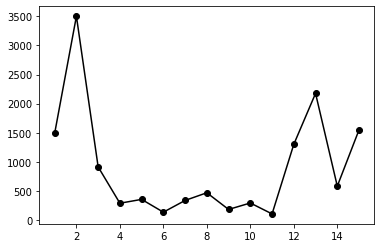

In [670]:
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data", load_only_control=True)
srate = 2000

amp_range_set = load_pickle("../information_routing/data/osc_motif/amp_range_set.pkl")["amp_range_set"]

cid = 8
# (5, 14)
# (8, 15)

print(amp_range_set[cid-1])
osc_motif = load_pickle("../information_routing/data/osc_motif/motif_info_%d.pkl"%(cid))["winfo"]
amp_range = amp_range_set[cid-1]["fpop"]

plt.figure()
num_motif = [len(w) for w in osc_motif]
num_motif[0] = np.nan
plt.plot(np.arange(16), num_motif, 'ko-')

In [671]:
detail = summary_obj.load_detail(0, 0)

In [672]:
detail["mua"].shape

(2, 21000)

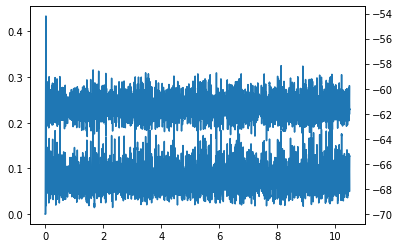

In [666]:
plt.plot(detail["ts"], detail['mua'][0])
plt.twinx()
plt.plot(detail["ts"], detail["vlfp"][1], c)
# plt.plot(detail["ts"], detail['mua'][1])

# Align the phase on the peak of voltage

In [352]:
cid = 4
amp_range_set[cid-1]

{'fpop': [[30, 40], [55, 65]], 'spop': [[30, 40], []]}

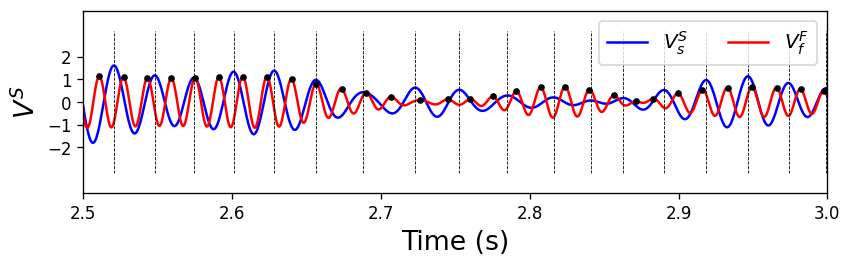

In [354]:
from scipy.signal import find_peaks

def draw_multi_vline(xset, yl):
    xs, ys = [], []
    for x in xset:
        xs.extend([x, x, np.nan])
        ys.extend([yl[0], yl[1], np.nan])
    
    plt.plot(xs, ys, 'k--', lw=0.5)

amp_range = amp_range_set[cid-1]["spop"]
    
data = summary_obj.load_detail(cid-1, 0)
# t, v = data["ts"], data["vlfp"][2]
t = data["ts"]

vfilt_s = filt(data["vlfp"][2], srate, [30, 40], fo=2)
vfilt_f = filt(data["vlfp"][1], srate, [55, 65], fo=2)

idp_s, _ = find_peaks(vfilt_s)
idp_f, _ = find_peaks(vfilt_f)

plt.figure(dpi=120, figsize=(8, 2), facecolor='w')
plt.plot(t, vfilt_s, c='b', label=r"$V^S_s$")# %(amp_range[0][0], amp_range[0][1]))
plt.plot(t, vfilt_f, c='r', label=r"$V^F_f$")# %(amp_range[1][0], amp_range[1][1]))
plt.legend(fontsize=12, loc="upper right", ncol=2)

plt.plot(t[idp_f], vfilt_f[idp_f], 'k.')
draw_multi_vline(t[idp_s], [-np.pi, np.pi])
plt.ylim([-4, 4])
plt.yticks(np.arange(-2, 2.1, 1))
plt.xlim([2.5, 3.])

plt.xlabel("Time (s)", fontsize=16)
plt.ylabel(r"$V^S$", fontsize=16)

plt.show()

In [18]:
# amp_range = [[30, 40], [55, 65]]

def load_phs(cid, nid, tp_phs="F"):
    data = summary_obj.load_detail(cid-1, nid)
    t = data["ts"]

    idt_eq = t >= 0.5
    vfilt_s = filt(data["vlfp"][2], 2000, amp_range[0])
    vfilt_f = filt(data["vlfp"][1], 2000, amp_range[1])
    t0 = t[idt_eq][0]
    
    if tp_phs == "F":
        va = vfilt_s
        vp = vfilt_f
    elif tp_phs == "S":
        va = vfilt_f
        vp = vfilt_s
    else:
        raise ValueError("Unexpected type")
    
    x, phs = va[idt_eq], np.angle(hilbert(vp))[idt_eq]
    phs_d = np.digitize(phs, e) - 1
    id_peak, _ = find_peaks(x)
    
    return phs_d, id_peak

{'fpop': [[30, 40], [62, 78]], 'spop': [[30, 40], [62, 78]]}


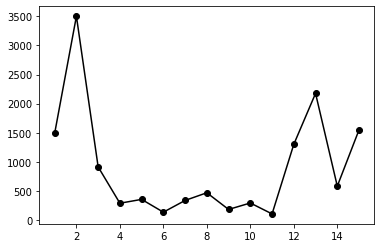

In [27]:
cid = 8

print(amp_range_set[cid-1])
amp_range = amp_range_set[cid-1]["spop"]

# nw_set = [2, 5, 7]
nw_set = [10, 15]

plt.figure()
num_motif = [len(w) for w in osc_motif]
num_motif[0] = np.nan
plt.plot(np.arange(16), num_motif, 'ko-')

In [30]:
""" Set parameters"""
nbin = 30
nw_set = [2, 13, 15]
tp_phs = "S"

""" Initialize """
e = np.linspace(-np.pi, np.pi, nbin+1)
phs_distrib = [np.zeros(nbin) for _ in nw_set]
phs_distrib_base = np.zeros(nbin)

""" compute phase """
# baseline
for nid in tqdm(range(800), desc="baseline"):
    phs_d, id_peak = load_phs(cid, nid, tp_phs=tp_phs)
    phs_distrib_base += count_1d(nbin, phs_d[id_peak])
    
# for each w_set
t0 = 0.5
for i, nw in enumerate(nw_set):
    nid_prv = -1
    motif_target = osc_motif[nw]
    for w in tqdm(motif_target, desc="nw: %d"%(nw)):
        nid, tl = w
        if nid != nid_prv: 
            phs_d, id_peak = load_phs(cid, nid, tp_phs=tp_phs)
            nid_prv = nid
    
        nl = ((tl - t0) * srate).astype(int)
        id_nl = (id_peak >= nl[0]) & (id_peak <= nl[1])
        phs_distrib[i] += count_1d(nbin, phs_d[id_peak[id_nl]])


baseline:   0%|          | 0/800 [00:00<?, ?it/s]

nw: 2:   0%|          | 0/3503 [00:00<?, ?it/s]

nw: 13:   0%|          | 0/2176 [00:00<?, ?it/s]

nw: 15:   0%|          | 0/1548 [00:00<?, ?it/s]

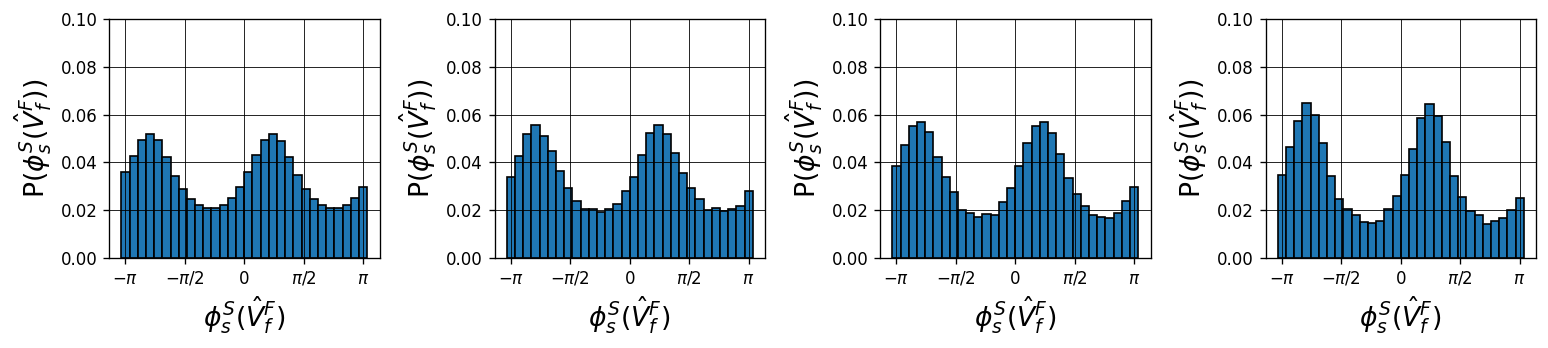

In [31]:
# Draw result
def norm(x):
    return x/x.sum()

if tp_phs == "F":
    n1, n2 = 1, 0
    ka, kp = "s", "f"
    tp_amp = "S"
else:
    n1, n2 = 0, 1
    ka, kp = "f", "s"
    tp_amp = "F"

yl = (0, 0.1)

x = np.linspace(-np.pi, np.pi, nbin)
dx = x[1] - x[0]
xt = np.linspace(-np.pi, np.pi, 5)
xt_label = (r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$")

# xlb_phi = r"$\phi^%s_{[%d, %d]}$"%(tp_phs, amp_range[n1][0], amp_range[n1][1])
# xlb_amp = r"$(\hat{V}^%s_{[%d, %d]})$"%(tp_amp, amp_range[n2][0], amp_range[n2][1])
xlb_phi = r"$\phi^%s_%s$"%(tp_phs, kp)
xlb_amp = r"$(\hat{V}^%s_%s)$"%(tp_amp, ka)
xlb = xlb_phi + xlb_amp

plt.figure(dpi=120, figsize=(13, 3.), facecolor='w')

N = len(nw_set) + 1
for n in range(N):
    
    phs = phs_distrib_base if n == 0 else phs_distrib[n-1] 
    
    plt.subplot(1, N, n+1)
    plt.bar(x, norm(phs), edgecolor='k', width=dx)
    plt.xticks(xt, labels=xt_label)
    plt.xlabel(xlb, fontsize=16)
    plt.ylabel("P("+xlb+")", fontsize=16)
    # plt.title("From entire time", fontsize=16)
    plt.ylim(yl)
    plt.grid(True, lw=0.5, c='k')

plt.tight_layout()
plt.savefig("./figs/#%d_phase(%s)_align.png"%(cid, tp_phs), bbox_inches="tight")
plt.show()

# Compute phase distribution in motif

In [15]:
def draw_phs_histogram(phs_distrib, phs_distrib_base=None,
                       xlb=None, ylb=None, yl=None, 
                       title=None, legend=True,
                       figsize=(3.5, 3)):
    fig = None
    if figsize is not None:
        fig = plt.figure(figsize=figsize, dpi=120)
        
    def _norm(p):
        return p/(p.sum()+1e-10)/dx
    
    def _draw_distrib(p, **kwargs):
        plt.fill_between(x, np.zeros_like(p), _norm(p), **kwargs)
    
    num =len(phs_distrib)
    dx = 2*np.pi/num
    x = np.linspace(-np.pi-dx/2, np.pi+dx/2, num)
    
    xt = np.arange(-np.pi, np.pi+1e-3, np.pi/4)
    xt_label = (r"$-\pi$", "", r"$-\pi/2$", "", "0", "", r"$\pi/2$", "", r"$\pi$")
    
    _draw_distrib(phs_distrib, label="motif")
    if phs_distrib_base is not None:
        _draw_distrib(phs_distrib_base, alpha=0.6, label="base")
        if legend:
            plt.legend(loc="upper right", fontsize=10)
    
    plt.xlim([x[0], x[-1]])
    plt.xlabel(xlb, fontsize=16)
    plt.ylabel(ylb, fontsize=16)
    plt.xticks(xt, labels=xt_label)
    plt.title(title, fontsize=16)
    plt.grid(True, lw=0.5, c='k', alpha=0.5)
    
    if yl is None:
        yl = plt.gca().get_ylim()
        yl = [0, yl[1]]
    plt.ylim(yl)
    
    return fig

{'fpop': [[], [62, 72]], 'spop': [[25, 35], [62, 72]]}
amp range: [[25, 35], [62, 72]]


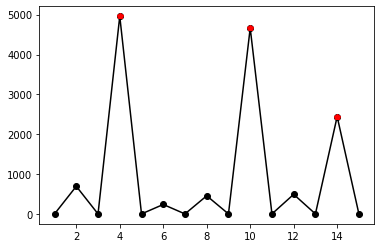

In [343]:
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data", load_only_control=True)
srate = 2000

amp_range_set = load_pickle("../information_routing/data/osc_motif/amp_range_set.pkl")["amp_range_set"]

cid = 5
# print(amp_range_set[cid-1])
osc_motif = load_pickle("../information_routing/data/osc_motif/motif_info_%d.pkl"%(cid))["winfo"]
# amp_range = amp_range_set[cid-1]["fpop"]
print(amp_range_set[cid-1])

""" 
Set target motif ID and amp_range
"""
nbin = 30
tp_phs = "F"
wid_set = [4, 10, 14]
amp_range = [[25, 35], [62, 72]]
print("amp range:", amp_range)


plt.figure()
num_motif = np.array([len(w) for w in osc_motif], dtype=np.float16)
num_motif[0] = np.nan
plt.plot(np.arange(16), num_motif, 'ko-')
plt.plot(wid_set, num_motif[wid_set], "rp")
plt.show()

In [344]:
""" Initialize """
e = np.linspace(-np.pi, np.pi, nbin+1)
phs_distrib = [np.zeros(nbin) for _ in wid_set]
phs_distrib_base = np.zeros(nbin)

""" compute phase """
# baseline
for nid in tqdm(range(800), desc="baseline"):
    phs_d, id_peak = load_phs(cid, nid, tp_phs=tp_phs)
    phs_distrib_base += count_1d(nbin, phs_d[id_peak])
    
# for each w_set
t0 = 0.5
for i, nw in enumerate(wid_set):
    nid_prv = -1
    motif_target = osc_motif[nw]
    for w in tqdm(motif_target, desc="nw: %d"%(nw)):
        nid, tl = w
        if nid != nid_prv: 
            phs_d, id_peak = load_phs(cid, nid, tp_phs=tp_phs)
            nid_prv = nid
    
        nl = ((tl - t0) * srate).astype(int)
        id_nl = (id_peak >= nl[0]) & (id_peak <= nl[1])
        phs_distrib[i] += count_1d(nbin, phs_d[id_peak[id_nl]])


baseline:   0%|          | 0/800 [00:00<?, ?it/s]

nw: 4:   0%|          | 0/4958 [00:00<?, ?it/s]

nw: 10:   0%|          | 0/4663 [00:00<?, ?it/s]

nw: 14:   0%|          | 0/2442 [00:00<?, ?it/s]

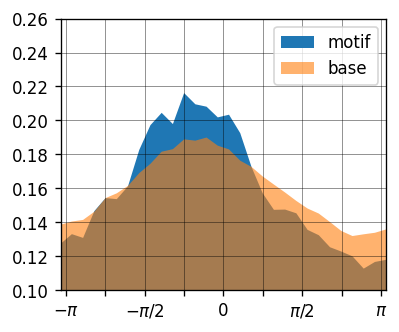

In [350]:
fig = draw_phs_histogram(phs_distrib[1], phs_distrib_base, yl=(0.1, 0.26))

In [351]:
if tp_phs == "F":
    ka, kp = "s", "f"
    tp_amp = "S"
else:
    ka, kp = "f", "s"
    tp_amp = "F"
    
# kp = "f"
    
xlb_phi = r"$\phi^%s_%s$"%(tp_phs, kp)
xlb_amp = r"$(\hat{V}^%s_%s)$"%(tp_amp, ka)
xlb = xlb_phi + xlb_amp
# yl = (0.1, 0.21)
# yl = (0, 4)
yl = (0.1, 0.26)

for n in range(len(wid_set)):
    wid = wid_set[n]
    lb = od.get_motif_labels()[wid]
    fig = draw_phs_histogram(phs_distrib[n], phs_distrib_base, yl=yl,
                             xlb=xlb, ylb="P("+xlb+")", title="#%d, %s"%(cid, lb))
    plt.savefig("./figs/phase(%s)_%d%02d.png"%(tp_phs, cid, wid), bbox_inches="tight")
    plt.clf()

<Figure size 420x360 with 0 Axes>

<Figure size 420x360 with 0 Axes>

<Figure size 420x360 with 0 Axes>

# CFC-table

In [12]:
from scipy.signal import find_peaks

@njit
def count_1d(nbin, xset):
    nbin_hist = np.zeros(nbin)
    for x in xset:
        nbin_hist[x] += 1
    return nbin_hist


def load_phs_set(cid, nid, amp_range_tp=None, e=None):
    data = summary_obj.load_detail(cid-1, nid)
    t = data["ts"]

    idt_eq = t >= 0.5
    t0 = t[idt_eq][0]
    
    phs_set = []
    id_peak_set = []
    
    for ntp in range(2): # S-F
        amp_range = amp_range_tp[ntp]
        for na in range(2): # s-f
            if len(amp_range[na]) == 0:
                phs_set.append([]); id_peak_set.append([])
                continue
            
            v = filt(data["vlfp"][2-ntp], 2000, amp_range[na])
            phs_sub = np.angle(hilbert(v))[idt_eq]
            v_sub = v[idt_eq]
            
            phs_d = np.digitize(phs_sub, e) - 1
            id_peak, _ = find_peaks(v_sub)
            
            phs_set.append(phs_d)
            id_peak_set.append(id_peak)
        
    return phs_set, id_peak_set

desc = ("Ss", "Sf", "Fs", "Ff")

srate = 2000
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data", load_only_control=True)
amp_range_set = load_pickle("../information_routing/data/osc_motif/amp_range_set.pkl")["amp_range_set"]

{'fpop': [[], [28, 45]], 'spop': [[], [20, 40]]}


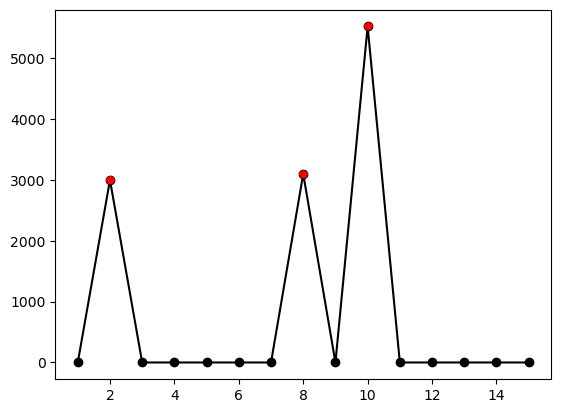

In [10]:
nbin = 21

cid = 2
osc_motif = load_pickle("../information_routing/data/osc_motif/motif_info_%d.pkl"%(cid))["winfo"]
print(amp_range_set[cid-1])

wid_set = [2, 8, 10]
# amp_range = [[25, 35], [62, 72]]
# print("amp range:", amp_range)

# amp_range_tp = [amp_range_set[cid-1]["spop"], amp_range_set[cid-1]["fpop"]]
amp_range_tp = [[[20, 30], [28, 45]], [[28, 45], [30, 45]]]

plt.figure()
num_motif = np.array([len(w) for w in osc_motif], dtype=np.float16)
num_motif[0] = np.nan
plt.plot(np.arange(16), num_motif, 'ko-')
plt.plot(wid_set, num_motif[wid_set], "rp")
plt.show()

In [29]:
hhsignal

<module 'hhsignal' from '/home/jungyoung/Project/hh_neuralnet/include/hhsignal.py'>

In [ ]:
_norm = lambda x: (x - x.mean())/x.std()
c, tc = hhsignal.get_correlation(_norm(phs_set[0]), _norm(phs_set[3]), 2000, max_lag=0.02)

In [ ]:
plt.plot(tc*1e3, c)

In [13]:
""" Initialize """
e = np.linspace(-np.pi, np.pi, nbin+1)
prob_phs_table = np.zeros((len(wid_set)+1, 4, 4, nbin)) # type, phase, Vpeak, ...

""" compute phase """
# baseline
t0 = 0.5

# baseline; out-of-motif
for nid in tqdm(range(800), desc="baseline"):
    phs_set, id_peak_set = load_phs_set(cid, nid, amp_range_tp, e=e)
    for kp in range(4):
        for ka in range(4):
            if len(phs_set[kp]) == 0 or len(id_peak_set[ka]) == 0:
                continue
            prob_phs_table[0,kp,ka] += count_1d(nbin, phs_set[kp][id_peak_set[ka]])

# motif
for nw, wid in enumerate(wid_set):
    nid_prv = -1
    motif_target = osc_motif[wid]
    for w in tqdm(motif_target, desc="nw: %d"%(wid)):
        nid, tl = w
        if nid != nid_prv:
            phs_set, id_peak_set = load_phs_set(cid, nid, amp_range_tp, e=e)
            nid_prv = nid
        
        nl = ((tl - t0) * srate).astype(int)
        for ka in range(4):
            id_peak = id_peak_set[ka]
            if len(id_peak) == 0: continue
            
            id_nl = (id_peak >= nl[0]) & (id_peak <= nl[1])
            for kp in range(4):
                if len(phs_set[kp]) == 0: continue
                
                prob_phs_table[nw+1,kp,ka] += count_1d(nbin, phs_set[kp][id_peak_set[ka][id_nl]])


baseline:   0%|          | 0/800 [00:00<?, ?it/s]

nw: 2:   0%|          | 0/3001 [00:00<?, ?it/s]

nw: 8:   0%|          | 0/3100 [00:00<?, ?it/s]

nw: 10:   0%|          | 0/5525 [00:00<?, ?it/s]

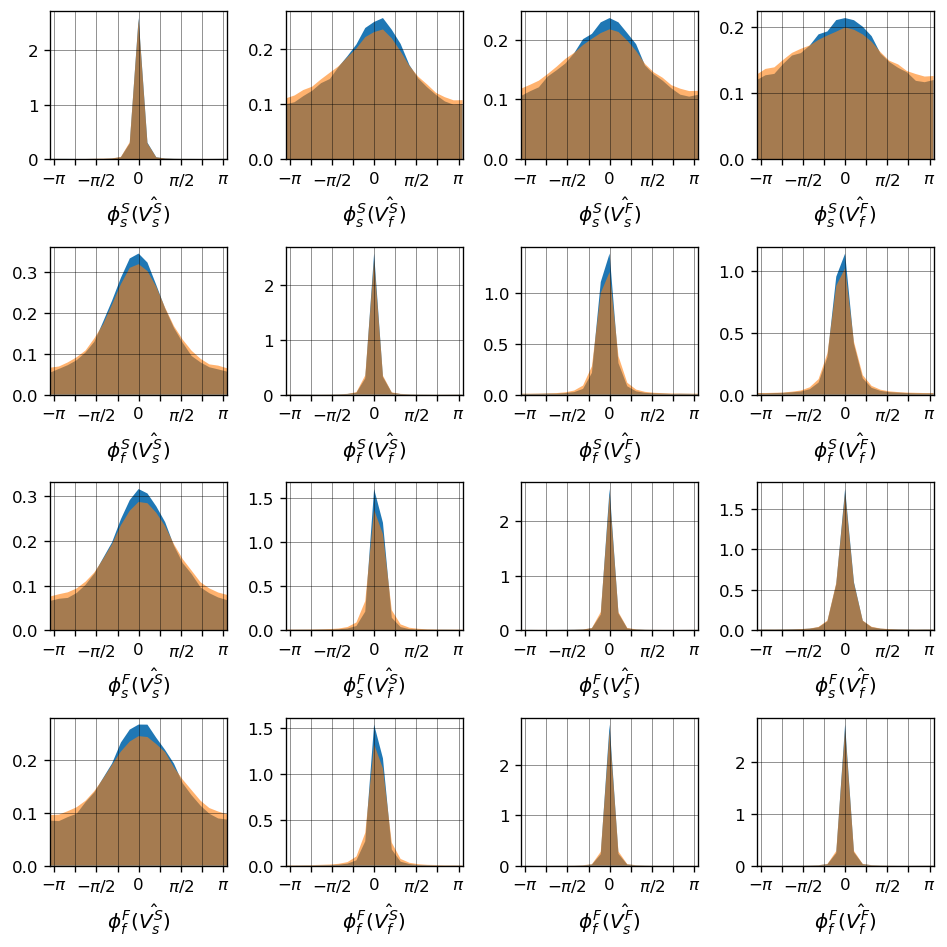

In [22]:
# combined version
tp_reg = ("S", "S", "F", "F")
tp_osc = ("s", "f", "s", "f")

nw = 0 # nw need to be positive

# plt.figure(figsize=(8, 8), dpi=120)
fig, axs = plt.subplots(4, 4, dpi=120, figsize=(8,8))
for kp in range(4):
    lb_p = r"$\phi^%s_%s$"%(tp_reg[kp], tp_osc[kp])
    for ka in range(4):
        p = prob_phs_table[nw,kp,ka]
        
        plt.sca(axs[kp][ka])
        
        if kp%2 != ka%2 and kp != ka:
            # yl = [0.05, 0.35]
            yl = None
        else:
            yl = None
        
        draw_phs_histogram(p,
                           prob_phs_table[0,kp,ka],
                           xlb=None,
                           yl=yl, figsize=None, legend=False)
        
        lb_a = r"$\hat{V^%s_%s}$"%(tp_reg[ka], tp_osc[ka])
        xlb = lb_p + "(" + lb_a + ")"
        
        plt.xlabel(xlb, fontsize=12)
        
plt.tight_layout()
plt.savefig("./figs/cfc_table_%d%02d(2).png"%(cid, wid_set[nw-1]), bbox_inches='tight')
plt.show()

In [501]:
plt.close()

In [590]:
# combined version
tp_reg = ("S", "S", "F", "F")
tp_osc = ("s", "f", "s", "f")

nw = 3
assert nw > 0
fdir = "./figs/cfc_split_%d%02d"%(cid, wid_set[nw-1])
try:
    os.makedirs(fdir)
except:
    pass
# !mkdir "./figs/cfc_split_%d%02d"%(cid, wid_set[nw-1])

for kp in range(4):
    lb_p = r"$\phi^%s_%s$"%(tp_reg[kp], tp_osc[kp])
    for ka in range(4):
        p = prob_phs_table[nw,kp,ka]
        if np.all(p == 0): continue
        
        if kp%2 != ka%2 and kp != ka:
            # yl = [0.05, 0.21]
            # yl = [0.05, 0.24]
            yl = None
        else:
            yl = None
        
        fig = draw_phs_histogram(p, prob_phs_table[0,kp,ka],
                                 xlb=xlb, yl=yl, figsize=(4, 4), legend=False)
        
        lb_a = r"$\hat{V^%s_%s}$"%(tp_reg[ka], tp_osc[ka])
        xlb = lb_p + "(" + lb_a + ")"
        plt.xlabel(xlb, fontsize=14)
        plt.ylabel("P("+xlb+")", fontsize=14)
        
        plt.savefig(os.path.join(fdir, "%d%d.png"%(kp, ka)), bbox_inches='tight')
        # plt.show()
        plt.close()
        # break
        
    # break
        
# plt.tight_layout()
# plt.savefig("./figs/cfc_table_%d%02d.png"%(cid, wid_set[nw-1]), bbox_inches='tight')
# plt.show()

In [ ]:
od.get_motif_labels()[6]

In [538]:
!rm figs/cfc_split_106/*

In [599]:
detail.keys()

dict_keys(['step_spk', 'vlfp', 'ts', 'nid', 'info'])

In [627]:
reload(hhsignal)

<module 'hhsignal' from '/home/jungyoung/Project/hh_neuralnet/include/hhsignal.py'>